In [1]:
import numpy as np
from scipy.fft import ifft2

In [2]:
def qpsk_mapper(bits):
    bit_pairs = bits.reshape(-1, 2)
    symbols = (1 - 2 * bit_pairs[:, 0]) + 1j * (1 - 2 * bit_pairs[:, 1])
    return symbols

In [3]:
print(qpsk_mapper(np.array([0, 1, 1, 0, 1, 1, 0, 0])))

[ 1.-1.j -1.+1.j -1.-1.j  1.+1.j]


In [4]:
def qpsk_demapper(symbols):
    bits = np.zeros(2 * len(symbols), dtype=int)
    bits[0::2] = symbols.real < 0  # MSB decision (Real part)
    bits[1::2] = symbols.imag < 0  # LSB decision (Imaginary part)
    return bits

In [5]:
print(qpsk_demapper(qpsk_mapper(np.array([0,1,1,0,1,1,0,0]))))

[0 1 1 0 1 1 0 0]


In [6]:
def apply_isfft(symbols, M, N):
    # Reshape input symbols into M x N matrix
    X = symbols.reshape(M, N)

    # Apply 2D inverse FFT (ISFFT)
    transformed_output = ifft2(X)

    return transformed_output

# Example Test
M, N = 4, 4  # Example OTFS frame size
qpsk_symbols = np.random.choice([1+1j, 1-1j, -1+1j, -1-1j], size=(M * N))  # Random QPSK symbols
isfft_output = apply_isfft(qpsk_symbols, M, N)
print(isfft_output)

[[ 0.125-0.125j  0.   -0.25j   0.375-0.125j  0.   -0.5j  ]
 [-0.25 +0.j     0.125+0.125j -0.25 +0.25j  -0.125-0.375j]
 [-0.125-0.125j  0.   +0.5j   -0.375-0.125j  0.   -0.25j ]
 [-0.25 -0.25j  -0.125-0.375j -0.25 +0.5j    0.125+0.125j]]


In [7]:
def apply_heisenberg_transform(isfft_output):
    # Flatten the matrix to a 1D array and apply IFFT
    transformed_output = np.fft.ifft(isfft_output.flatten())

    return transformed_output

# Example Test
M, N = 4, 4  # Example OTFS frame size
qpsk_symbols = np.random.choice([1+1j, 1-1j, -1+1j, -1-1j], size=(M * N))  # Random QPSK symbols
isfft_output = apply_isfft(qpsk_symbols, M, N)
heisenberg_output = apply_heisenberg_transform(isfft_output)

print("\nISFFT Output:\n", isfft_output)
print("\nHeisenberg Transform Output:\n", heisenberg_output)


ISFFT Output:
 [[-0.125+0.5j    0.25 -0.125j -0.125+0.25j   0.   -0.125j]
 [ 0.5  -0.125j -0.125-0.25j  -0.5  -0.375j  0.625-0.25j ]
 [ 0.125+0.j     0.   -0.125j  0.125-0.25j  -0.25 -0.125j]
 [ 0.   +0.125j  0.375+0.j     0.   -0.125j  0.125+0.j   ]]

Heisenberg Transform Output:
 [ 0.0625    -0.0625j      0.02391771+0.08641771j -0.01830583+0.01830583j
 -0.09417718-0.02546117j  0.0625    +0.0625j      0.05774247+0.12024247j
 -0.04419417-0.04419417j  0.00775947+0.04937888j -0.0625    +0.0625j
 -0.02391771+0.03858229j -0.10669417+0.10669417j -0.01251699-0.10712135j
  0.0625    +0.0625j     -0.05774247+0.00475753j  0.04419417+0.04419417j
 -0.02606529+0.08320364j]


In [10]:
def add_awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = signal_power / snr_linear

    # Generate complex Gaussian noise
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))

    # Add noise to signal
    received_signal = signal + noise

    return received_signal


In [13]:
snr_value = 10  # Example SNR in dB
noisy_signal = add_awgn(heisenberg_output, snr_value)
print(noisy_signal)

[ 0.07246159+0.05750162j  0.08319723-0.03424418j  0.00917569-0.14425097j
 -0.04160603-0.0449446j  -0.07161885+0.04368475j  0.09249843-0.04299738j
 -0.00056739-0.05556718j  0.14918183-0.00562997j -0.0662426 +0.01642226j
  0.10890306-0.0949521j   0.0325372 -0.01401645j -0.01428966-0.09246241j
  0.0536337 +0.06983673j -0.01472249+0.05032004j  0.00287523-0.06607612j
 -0.06723925-0.00203626j]


In [14]:
import numpy as np
from scipy.fft import ifft2, fft2

def apply_isfft(symbols, M, N):
    """
    Applies Inverse Symplectic Finite Fourier Transform (ISFFT) on input symbols.

    Parameters:
    symbols (numpy array): Input complex symbols (M*N elements).
    M (int): Number of delay bins.
    N (int): Number of Doppler bins.

    Returns:
    numpy array: M x N matrix after ISFFT.
    """
    X = symbols.reshape(M, N)  # Reshape to M x N matrix
    transformed_output = ifft2(X)  # Apply 2D inverse FFT (ISFFT)

    return transformed_output

def apply_heisenberg_transform(isfft_output):
    """
    Applies Heisenberg transform to convert ISFFT output to time domain.

    Parameters:
    isfft_output (numpy array): M x N ISFFT output matrix.

    Returns:
    numpy array: 1D time-domain sequence (M*N elements).
    """
    return np.fft.ifft(isfft_output.flatten())  # Apply 1D IFFT

def apply_wigner_transform(heisenberg_output, M, N):
    """
    Applies Wigner transform (SFFT) to convert time-domain signal back to delay-Doppler domain.

    Parameters:
    heisenberg_output (numpy array): 1D time-domain sequence (M*N elements).
    M (int): Number of delay bins.
    N (int): Number of Doppler bins.

    Returns:
    numpy array: M x N Wigner transformed matrix.
    """
    reshaped_input = heisenberg_output.reshape(M, N)  # Reshape to M x N matrix
    transformed_output = fft2(reshaped_input)  # Apply 2D FFT (SFFT)

    return transformed_output

def apply_sfft(wigner_output):
    """
    Applies Symplectic Finite Fourier Transform (SFFT) on input data.

    Parameters:
    wigner_output (numpy array): M x N Wigner transformed matrix.

    Returns:
    numpy array: M x N matrix after applying SFFT.
    """
    transformed_output = fft2(wigner_output)  # Apply 2D FFT (SFFT)
    return transformed_output

def add_awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = signal_power / snr_linear

    # Generate complex Gaussian noise
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))

    # Add noise to signal
    received_signal = signal + noise

    return received_signal


def apply_qpsk_demodulation_to_bitstream(sfft_output):
    """
    Demodulates QPSK symbols and returns a 1D binary sequence.

    Parameters:
    sfft_output (numpy array): M x N matrix containing received complex symbols.

    Returns:
    numpy array: 1D binary sequence (length M*N*2).
    """
    qpsk_mapping = {
        1+1j: [0, 0],
        1-1j: [0, 1],
        -1+1j: [1, 0],
        -1-1j: [1, 1]
    }

    # Find the closest QPSK symbol and map it to bits
    demodulated_bits = np.array([
        qpsk_mapping[min(qpsk_mapping.keys(), key=lambda x: abs(x - val))]
        for val in sfft_output.flatten()
    ]).flatten()  # Convert to 1D binary sequence

    return demodulated_bits

# Example Test
M, N = 4, 4  # Example OTFS frame size
qpsk_symbols = np.random.choice([1+1j, 1-1j, -1+1j, -1-1j], size=(M * N))  # Random QPSK symbols

# Step 1: Apply ISFFT
isfft_output = apply_isfft(qpsk_symbols, M, N)

# Step 2: Apply Heisenberg Transform
heisenberg_output = apply_heisenberg_transform(isfft_output)

snr_value = 10  # Example SNR in dB
noisy_signal = add_awgn(heisenberg_output, snr_value)
# print(noisy_signal)

# Step 3: Apply Wigner Transform (SFFT)
wigner_output = apply_wigner_transform(noisy_signal, M, N)

# Step 4: Apply SFFT
sfft_output = apply_sfft(wigner_output=wigner_output)

# Step 5: Apply QPSK Demodulation
demodulated_symbols = apply_qpsk_demodulation_to_bitstream(sfft_output)

# Print Outputs
print("\nInput QPSK Symbols Matrix:\n", qpsk_symbols.reshape(M, N))
print("\nISFFT Output (M x N):\n", isfft_output)
print("\nHeisenberg Transform Output (Flattened Time-Domain Signal):\n", heisenberg_output)
print("\nNoisy Signal (AWGN Added):\n", noisy_signal)
print("\nWigner Transform Output (M x N Matrix):\n", wigner_output)
print("\nSFFT Output (M x N Matrix):\n", sfft_output)
print("\nQPSK Demodulated Symbols (M x N Matrix):\n", demodulated_symbols)


Input QPSK Symbols Matrix:
 [[-1.-1.j -1.-1.j  1.+1.j  1.-1.j]
 [ 1.-1.j -1.+1.j  1.+1.j  1.+1.j]
 [ 1.-1.j  1.-1.j  1.-1.j  1.+1.j]
 [-1.-1.j  1.+1.j  1.+1.j  1.-1.j]]

ISFFT Output (M x N):
 [[ 0.5  -0.125j -0.25 -0.625j  0.   -0.125j -0.25 -0.125j]
 [-0.375+0.j    -0.125+0.j     0.125+0.5j   -0.125+0.j   ]
 [ 0.   -0.375j  0.25 +0.125j  0.   +0.125j -0.25 +0.125j]
 [-0.125+0.j    -0.375-0.5j   -0.125+0.j     0.125+0.j   ]]

Heisenberg Transform Output (Flattened Time-Domain Signal):
 [-0.0625    -0.0625j     -0.00775947-0.08684489j  0.13794417-0.03125j
  0.08899247+0.05152646j  0.0625    -0.0625j      0.09417718-0.05255776j
 -0.01294417-0.03125j     0.05516771+0.0447983j   0.0625    +0.0625j
  0.02606529+0.04265072j  0.04955583-0.03125j    -0.02649247+0.09936189j
 -0.0625    -0.0625j      0.01251699+0.09675194j  0.07544417-0.03125j
  0.00733229-0.07068664j]

Noisy Signal (AWGN Added):
 [-0.06433932-0.05494734j -0.01769311-0.09363504j  0.13926484-0.04338499j
  0.11279427+0.04375857j

In [18]:
input_bits = np.random.randint(0, 2, size=32)
qpsk_modulate = qpsk_mapper(input_bits)
isfft_output = apply_isfft(qpsk_modulate, 4, 4)
heisenberg_output = apply_heisenberg_transform(isfft_output=isfft_output)
noisy_signal = add_awgn(heisenberg_output, snr_db=10)  # Adding AWGN noise with SNR of 10 dB
wigner_output = apply_wigner_transform(heisenberg_output=noisy_signal, M=4, N=4)
sfft_output = apply_sfft(wigner_output=wigner_output)
output_bits = apply_qpsk_demodulation_to_bitstream(sfft_output=sfft_output)

print(input_bits)
print(output_bits)


[0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
[0 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0]


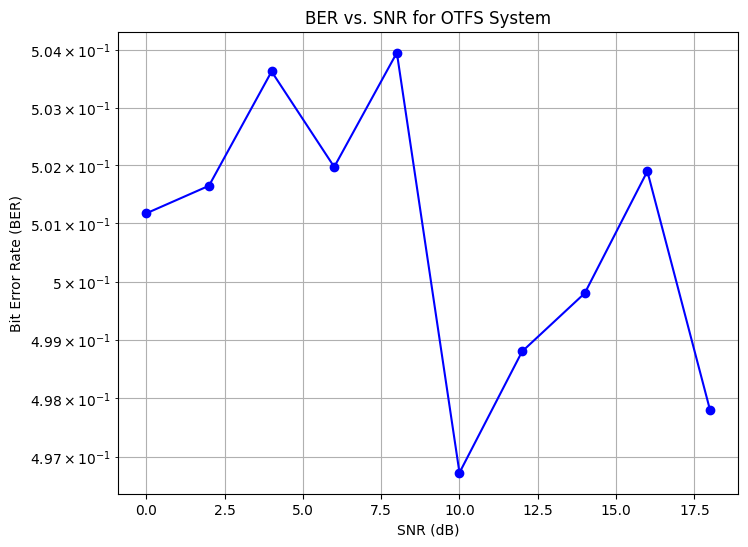

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import ifft2, fft2

# QPSK Mapper
def qpsk_mapper(bits):
    bit_pairs = bits.reshape(-1, 2)
    symbols = (1 - 2 * bit_pairs[:, 0]) + 1j * (1 - 2 * bit_pairs[:, 1])
    return symbols

# QPSK Demapper
def qpsk_demapper(symbols):
    bits = np.zeros(2 * len(symbols), dtype=int)
    bits[0::2] = symbols.real < 0
    bits[1::2] = symbols.imag < 0
    return bits

# ISFFT
def apply_isfft(symbols, M, N):
    return ifft2(symbols.reshape(M, N))

# Heisenberg Transform
def apply_heisenberg_transform(isfft_output):
    return np.fft.ifft(isfft_output.flatten())

# Add AWGN Noise
def add_awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

# Wigner Transform (SFFT)
def apply_wigner_transform(heisenberg_output, M, N):
    return fft2(heisenberg_output.reshape(M, N))

# SFFT
def apply_sfft(wigner_output):
    return fft2(wigner_output)

# QPSK Demodulation
def apply_qpsk_demodulation_to_bitstream(sfft_output):
    return qpsk_demapper(sfft_output.flatten())

# Compute BER for a given SNR
def compute_ber(snr_db, num_bits=40000, M=10000, N=2):
    input_bits = np.random.randint(0, 2, size=num_bits)
    qpsk_modulated = qpsk_mapper(input_bits)
    isfft_output = apply_isfft(qpsk_modulated, M, N)
    heisenberg_output = apply_heisenberg_transform(isfft_output)
    noisy_signal = add_awgn(heisenberg_output, snr_db)
    wigner_output = apply_wigner_transform(noisy_signal, M, N)
    sfft_output = apply_sfft(wigner_output)
    output_bits = apply_qpsk_demodulation_to_bitstream(sfft_output)

    bit_errors = np.sum(input_bits != output_bits[:num_bits])
    ber = bit_errors / num_bits
    return ber

# Simulate BER vs. SNR
snr_range = np.arange(0, 20, 2)  # SNR from 0 to 20 dB
ber_values = [compute_ber(snr) for snr in snr_range]

# Plot BER vs. SNR
plt.figure(figsize=(8, 6))
plt.semilogy(snr_range, ber_values, marker='o', linestyle='-', color='b')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("BER vs. SNR for OTFS System")
plt.grid(True, which='both')
plt.show()
